In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Callable
from functools import partial

In [19]:
def alpha_beta_gamma_filter(data, model_dynamics:Callable, update_state:Callable, alpha=None, beta=None, gamma=None, initial_state=0):
    x = np.zeros((data.shape[0], initial_state.shape[0]))  # Filtered state
    print(x.shape)
    x_prior = model_dynamics(initial_state.copy())  # Initial state prior
    z = data  # Observations
    results = []
    if alpha is None and beta is None and gamma is None:
        gain_calculate = lambda t, alpha, beta, gamma: (1 / (t+1), 1 / (t+1), 1 / (t+1))
    else:
        gain_calculate = lambda t, alpha, beta, gamma: (alpha, beta, gamma)

    for t in range(x.shape[0]):
        # Calculate Gain
        alpha, beta, gamma = gain_calculate(t, alpha, beta, gamma)
        print(alpha, beta, gamma)
        x[t] = update_state(x_prior, z[t], alpha, beta, gamma)
        x_prior = model_dynamics(x[t])
        results.append(x_prior)
    return x, np.array(results)

(10, 1)
1.0 1.0 1.0
0.5 0.5 0.5
0.3333333333333333 0.3333333333333333 0.3333333333333333
0.25 0.25 0.25
0.2 0.2 0.2
0.16666666666666666 0.16666666666666666 0.16666666666666666
0.14285714285714285 0.14285714285714285 0.14285714285714285
0.125 0.125 0.125
0.1111111111111111 0.1111111111111111 0.1111111111111111
0.1 0.1 0.1


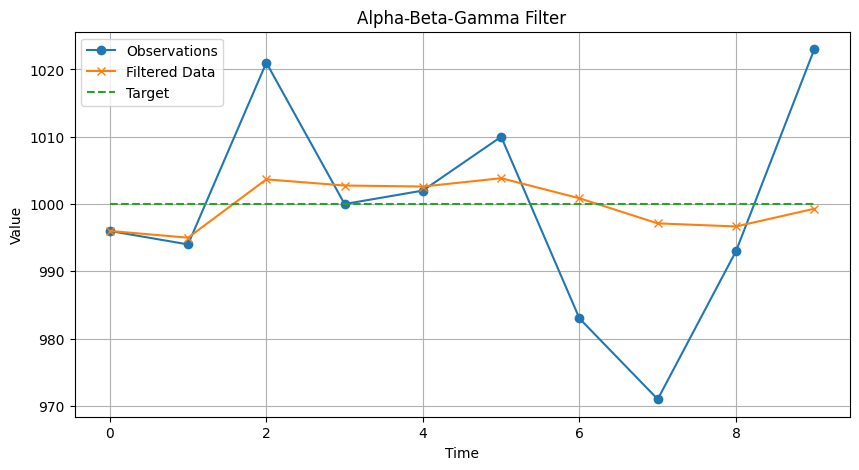

In [20]:
# Example usage Gole Weights
def gold_model_dynamics(x):
    return x  # Simple model where the state does not change

def gold_update_state(x_prior, z, alpha, beta, gamma):
    return x_prior + alpha * (z - x_prior)

z = np.array([996, 994, 1021, 1000, 1002, 1010, 983, 971, 993, 1023]).reshape(-1, 1)
initial_guess = np.array([1000])
filtered_data, _ = alpha_beta_gamma_filter(z, model_dynamics=gold_model_dynamics, update_state=gold_update_state, alpha=None, initial_state=initial_guess)

y = np.ones_like(z) * 1000

plt.figure(figsize=(10, 5))
plt.plot(z, label='Observations', marker='o')
plt.plot(filtered_data, label='Filtered Data', marker='x')
plt.plot(y, label='Target', linestyle='--')
plt.title('Alpha-Beta-Gamma Filter')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

(10, 2)
0.2 0.1 None
0.2 0.1 None
0.2 0.1 None
0.2 0.1 None
0.2 0.1 None
0.2 0.1 None
0.2 0.1 None
0.2 0.1 None
0.2 0.1 None
0.2 0.1 None
[[30194.2           39.42      ]
 [30383.64          38.654     ]
 [30612.728         42.2358    ]
 [30818.9256        41.73766   ]
 [31025.69112       41.545382  ]
 [31242.334424      42.4370214 ]
 [31418.8156248     38.86663078]
 [31566.31902296    34.18365521]
 [31739.38983919    34.39890923]
 [31964.10750826    39.67122152]]


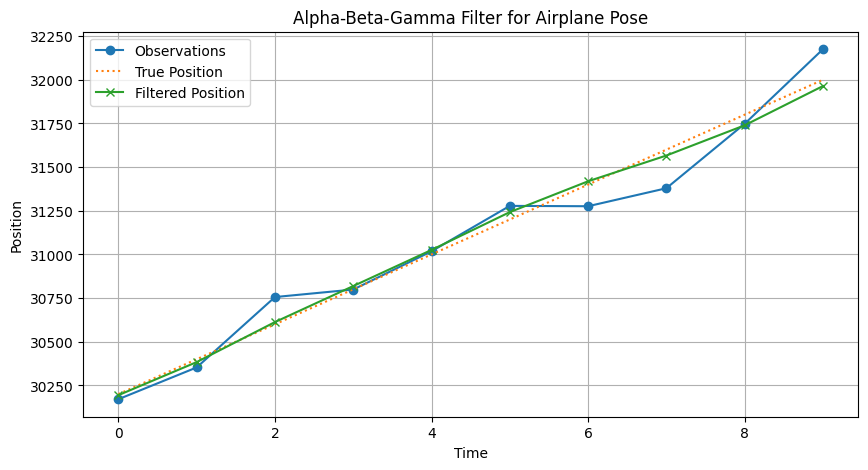

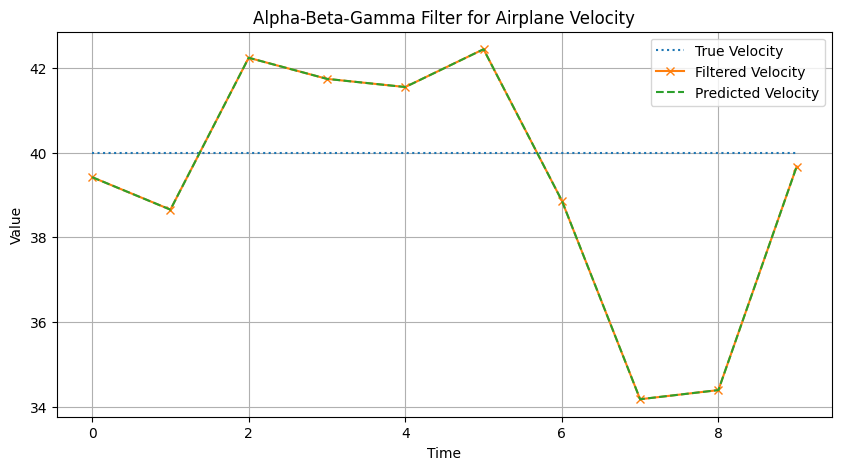

In [21]:
# Example usage Aitrplane Pose and Velocity
def airplane_model_dynamics(x, delta_t):
    return np.array([x[0] + delta_t * x[1], x[1]]).reshape(2,)  # Simple model where the position changes with velocity

def airplane_update_state(x_prior, z, alpha, beta, gamma, delta_t):
    return np.array([x_prior[0] + alpha * (z - x_prior[0]), x_prior[1] + beta/delta_t * (z - x_prior[0])]).reshape(2,)  # Update position and velocity

# true values is a static velocity of 40 and a position that changes with time
y_velocity = 40
y_position = np.array([30000 + y_velocity * (i+1) * 5 for i in range(10)]).reshape(-1, 1)

# measuements are noisy observations of the position (gaussian noise)
np.random.seed(42)
z = y_position + np.random.normal(0, 1000, size=y_position.shape)
z = z.reshape(-1, 1)  # Reshape to a column vector
# 30171 30353 30756 30799 31018 31278 31276 31379 31748 32175
z = np.array([30171, 30353, 30756, 30799, 31018, 31278, 31276, 31379, 31748, 32175]).reshape(-1, 1)

intial_guess = np.array([30000, 40])  # Initial position and velocity
alpha = 0.2
beta = 0.1
delta_t = 5  # Time step
filtered_data, predictions = alpha_beta_gamma_filter(z, model_dynamics=partial(airplane_model_dynamics, delta_t=delta_t), 
                                        update_state=partial(airplane_update_state, delta_t=delta_t), 
                                        alpha=alpha, beta=beta, initial_state=intial_guess)

print(filtered_data)

plt.figure(figsize=(10, 5))
plt.plot(z, label='Observations', marker='o')
plt.plot(y_position, label='True Position', linestyle=':')
plt.plot(filtered_data[:, 0], label='Filtered Position', marker='x')
plt.title('Alpha-Beta-Gamma Filter for Airplane Pose')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_velocity * np.ones_like(z), label='True Velocity', linestyle=':')
plt.plot(filtered_data[:, 1], label='Filtered Velocity', marker='x')
plt.plot(predictions[:, 1], label='Predicted Velocity', linestyle='--')
plt.title('Alpha-Beta-Gamma Filter for Airplane Velocity')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

(8, 3)
0.5 0.4 0.1
0.5 0.4 0.1
0.5 0.4 0.1
0.5 0.4 0.1
0.5 0.4 0.1
0.5 0.4 0.1
0.5 0.4 0.1
0.5 0.4 0.1


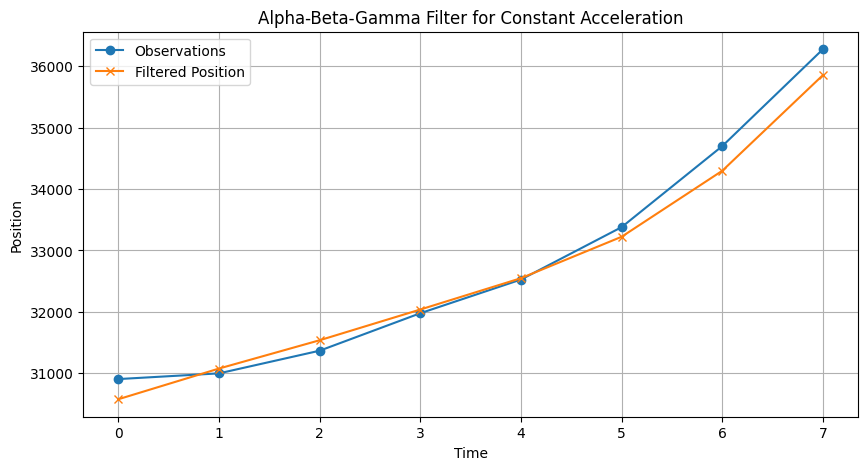

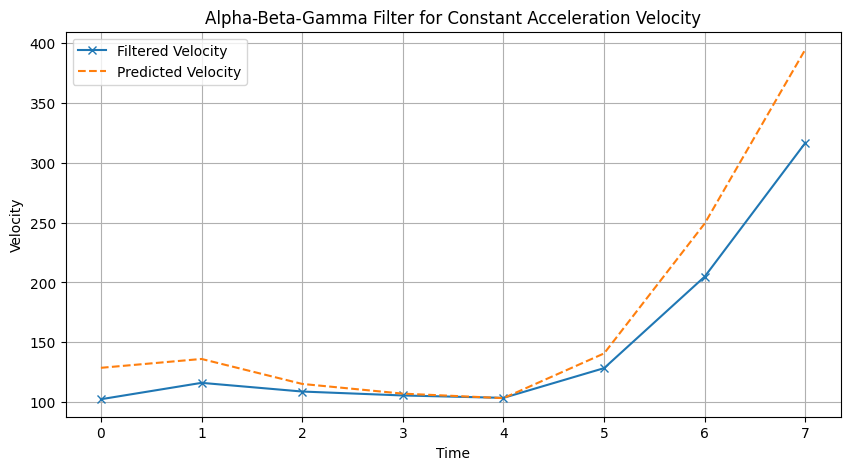

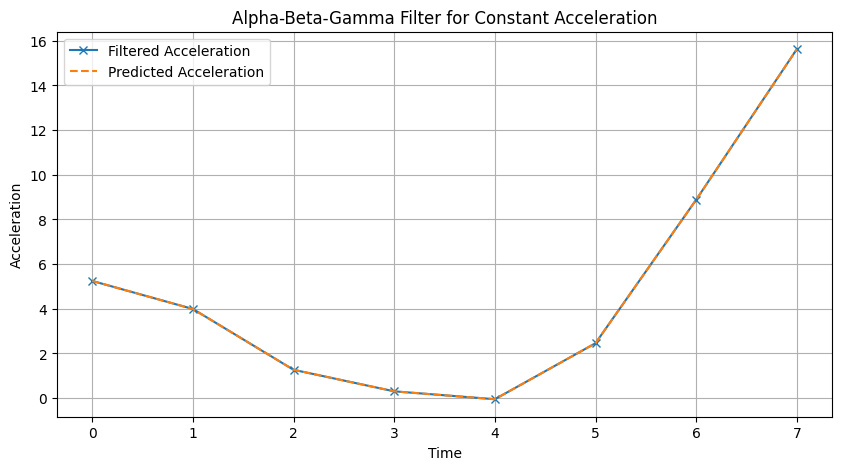

In [22]:
# Example usage with constant acceleration
def constant_acceleration_model_dynamics(x, delta_t):
    return np.array([x[0] + delta_t * x[1] + 0.5 * delta_t**2 * x[2], 
                     x[1] + delta_t * x[2], 
                     x[2]]).reshape(3,)  # Position, velocity, and acceleration

def constant_acceleration_update_state(x_prior, z, alpha, beta, gamma, delta_t):
    return np.array([x_prior[0] + alpha * (z - x_prior[0]), 
                     x_prior[1] + beta/delta_t * (z - x_prior[0]), 
                     x_prior[2] + gamma/(delta_t * delta_t * 0.5) * (z - x_prior[0])]).reshape(3,)  # Update position, velocity, and acceleration

alpha = 0.5
beta = 0.4
gamma = 0.1

z = np.array([30906, 30999, 31368, 31978, 32526, 33379, 34698, 36275]).reshape(-1, 1)  # Noisy observations of position
initial_guess = np.array([30000, 50, 0])  # Initial position, velocity, and acceleration
delta_t = 5  # Time step
filtered_data, predictions = alpha_beta_gamma_filter(z, model_dynamics=partial(constant_acceleration_model_dynamics, delta_t=delta_t), 
                                        update_state=partial(constant_acceleration_update_state, delta_t=delta_t), 
                                        alpha=alpha, beta=beta, gamma=gamma, initial_state=initial_guess)

plt.figure(figsize=(10, 5))
plt.plot(z, label='Observations', marker='o')
plt.plot(filtered_data[:, 0], label='Filtered Position', marker='x')
plt.title('Alpha-Beta-Gamma Filter for Constant Acceleration')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_data[:, 1], label='Filtered Velocity', marker='x')
plt.plot(predictions[:, 1], label='Predicted Velocity', linestyle='--')
plt.title('Alpha-Beta-Gamma Filter for Constant Acceleration Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_data[:, 2], label='Filtered Acceleration', marker='x')
plt.plot(predictions[:, 2], label='Predicted Acceleration', linestyle='--')
plt.title('Alpha-Beta-Gamma Filter for Constant Acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.grid()
plt.show()